# **Baseline Model for Trash Detection in Water Bodies**

## Model Overview

In this project, we developed a baseline object detection model using a YOLO architecture to detect trash in images and videos captured from water bodies. The dataset contains 3798 images with 19 classes of garbage items, many of which have overlapping labels. For our initial experiments, we retained all classes and focused on identifying trash objects using pre-trained model weights. Our goal was to gain familiarity with the dataset and establish a reference point in terms of performance before pursuing deeper model experiments. 

The experiments included two main parts:
- **Image Evaluation:** We performed inference on a set of images and computed key metrics such as precision, recall, F1 score, and overall accuracy using Intersection-over-Union (IoU) as the evaluation criterion.
- **Video Processing:** The model was also applied to videos to visualize detection performance over time, with bounding boxes drawn on frames to indicate the locations of detected trash.


In [ ]:

!pip install ultralytics --quiet

import os
import cv2
import torch
from ultralytics import YOLO
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Load model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = YOLO("/kaggle/input/yolov12/pytorch/default/1/v12strain1.pt").to(device)

# Model class names
model_names = model.names

# Define trash class IDs
trash_labels = set([
    'Bottle cap', 'Can', 'Juice Box', 'Juice box', 'Metal', 'Metal Waste',
    'Plastic', 'Plastic Bag', 'Plastic Bottle', 'Plastic Waste', 'Plastic bag',
    'Plastic bottle', 'Plastic cup', 'Plastic packaging', 'Plastic-Bottle',
    'Undefined trash', 'Wood', 'bottles', 'plastic'
])
trash_class_ids = {i for i, name in model_names.items() if name in trash_labels}

# Dataset paths
image_dir = "/kaggle/input/waste-in-water/test/images"
label_dir = "/kaggle/input/waste-in-water/test/labels"

def iou(box1, box2):
    """Compute IoU between two boxes in [x1, y1, x2, y2] format"""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou_value = interArea / float(box1Area + box2Area - interArea)
    return iou_value

# Evaluate
tp, fp, fn = 0, 0, 0
iou_threshold = 0.5

valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_exts)]

for img_file in image_files:
    base = os.path.splitext(img_file)[0]
    label_path = os.path.join(label_dir, base + ".txt")
    img_path = os.path.join(image_dir, img_file)

    # Load image
    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    # Load ground truth boxes
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                if class_id in trash_class_ids:
                    cx, cy, bw, bh = map(float, parts[1:])
                    x1 = (cx - bw / 2) * w
                    y1 = (cy - bh / 2) * h
                    x2 = (cx + bw / 2) * w
                    y2 = (cy + bh / 2) * h
                    gt_boxes.append([x1, y1, x2, y2])

    # Predict
    results = model(image)
    pred_boxes = []
    for i, pred_cls in enumerate(results[0].boxes.cls):
        class_id = int(pred_cls)
        if class_id in trash_class_ids:
            box = results[0].boxes.xyxy[i].cpu().numpy()  # x1, y1, x2, y2
            pred_boxes.append(box)

    matched_gt = set()
    matched_pred = set()

    # Match predicted boxes with GT using IoU
    for i, pbox in enumerate(pred_boxes):
        for j, gtbox in enumerate(gt_boxes):
            if j in matched_gt:
                continue
            if iou(pbox, gtbox) >= iou_threshold:
                tp += 1
                matched_gt.add(j)
                matched_pred.add(i)
                break

    fp += len(pred_boxes) - len(matched_pred)
    fn += len(gt_boxes) - len(matched_gt)

# Compute metrics
precision = tp / (tp + fp) if (tp + fp) else 0.0
recall = tp / (tp + fn) if (tp + fn) else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
accuracy = tp / (tp + fp + fn) if (tp + fp + fn) else 0.0


print("Object Detection Evaluation (Trash Objects Only)")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 23.7 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 640x640 2 Plastics, 15.3ms
Speed: 10.4ms preprocess, 15.3ms inference, 253.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 14.2ms
Speed: 2.8ms preprocess, 14.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Plastic cup, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Metal Waste, 13.8ms
Speed: 1.6ms preprocess, 13.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Plastic Bottle, 13.1ms
Speed: 1.6ms preprocess, 13.1ms inferenc

## Evaluation Results and Analysis

After running the baseline model on our test images, we computed several evaluation metrics:
- **0.3040** - **Accuracy:**  Measures the proportion of correctly detected trash objects relative to the total number of detection attempts.
- **0.5764** - **Precision:** Indicates the fraction of predicted trash objects that are truly correct.
- **0.3915** - **Recall:** Shows the fraction of actual trash objects that were successfully detected.
- **0.4663** - **F1 Score:** Combines precision and recall into a single metric, representing the balance between the two.

### Observed Issues in Performance

While the initial results were passable, further inspection revealed several areas where the model performance was less than ideal:
- **Low Accuracy on Small Objects:** The model struggled to correctly identify very small trash items. The low spatial resolution of these objects in the frame resulted in weak feature representation.
- **False Positives:** There were instances where the model classified non-water objects as trash. This suggests that the model sometimes misinterprets parts of the background or non-target objects as potential trash.
- **Difficulty with Reflections:** Reflections on the water’s surface and other reflective artifacts in images posed challenges. The model occasionally detected these reflections as trash, further reducing the precision of the results.
- **General Variability:** The dataset includes a variety of environmental conditions. Variability in lighting, water clarity, and scene complexity may contribute to suboptimal detection in some scenarios.

Overall, these issues translate into lower-than-desired precision and recall, impacting the F1 score and overall detection accuracy. This points to a need for refining both the data preparation and model architecture to improve robustness against such artifacts.

---

## Visualization of Detection Results on Images

In this section, we randomly select a subset of test images from our dataset to visually inspect the performance of our detection model. The following steps are performed for each selected image:

- **Loading and Preprocessing:** Each image is loaded using OpenCV and a copy is made for annotation.
- **Ground Truth Annotation:** If available, ground truth bounding boxes are drawn in red. The box coordinates are computed using the normalized parameters from the label files.
- **Prediction Annotation:** The model’s predicted bounding boxes are drawn in green. Each prediction is tagged with "Pred" to distinguish these from the ground truth.
- **Conversion for Visualization:** The annotated images are converted from BGR (used by OpenCV) to RGB (used by matplotlib) and then plotted.
  
This visual inspection helps in understanding which cases the baseline model handles well and where it struggles (e.g., detecting small or reflective trash items).




0: 640x640 1 Plastic cup, 14.5ms
Speed: 2.6ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


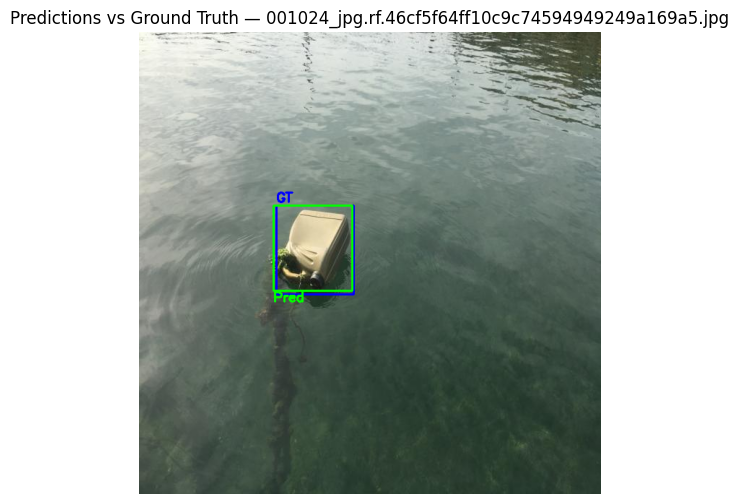


0: 640x640 1 Metal, 1 Metal Waste, 14.1ms
Speed: 1.6ms preprocess, 14.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


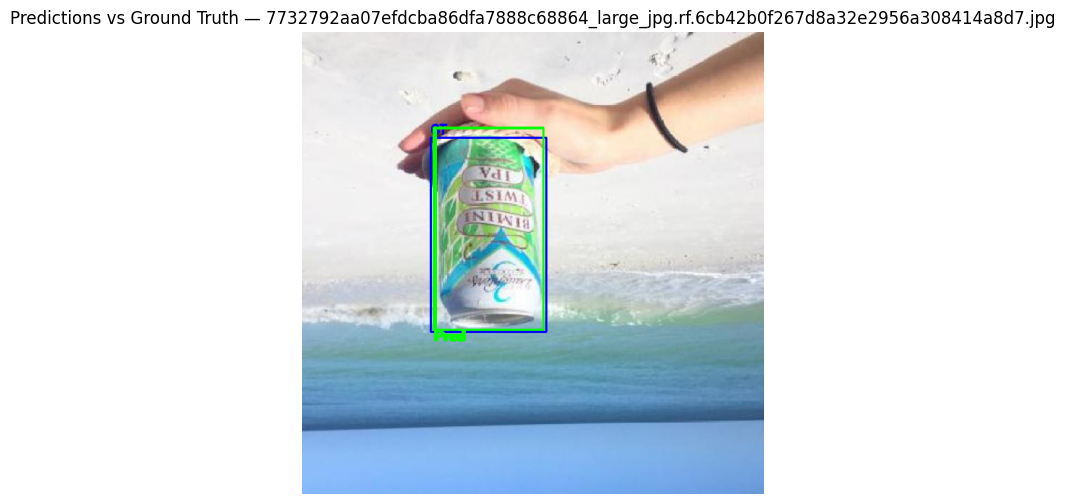


0: 640x640 1 Plastic bottle, 14.2ms
Speed: 1.6ms preprocess, 14.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


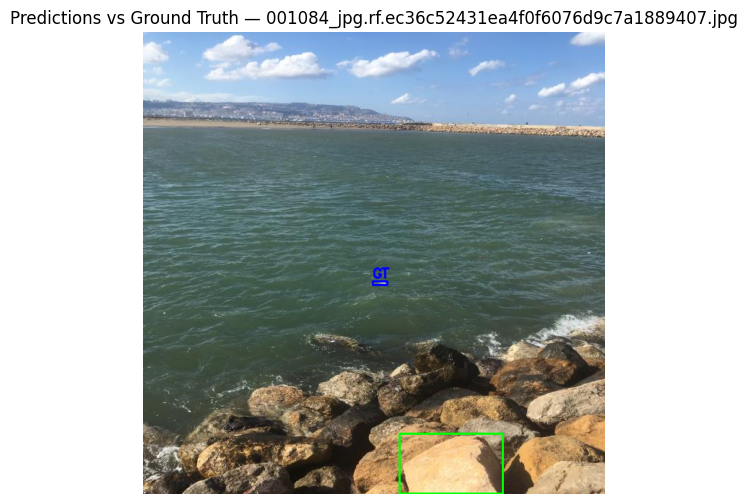


0: 640x640 1 Metal Waste, 14.5ms
Speed: 1.7ms preprocess, 14.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


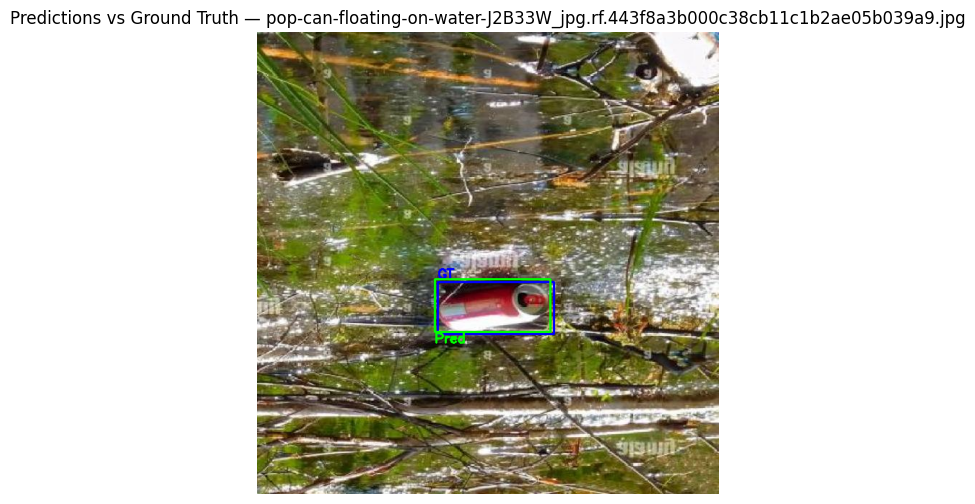


0: 640x640 1 Plastic bag, 14.2ms
Speed: 1.5ms preprocess, 14.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


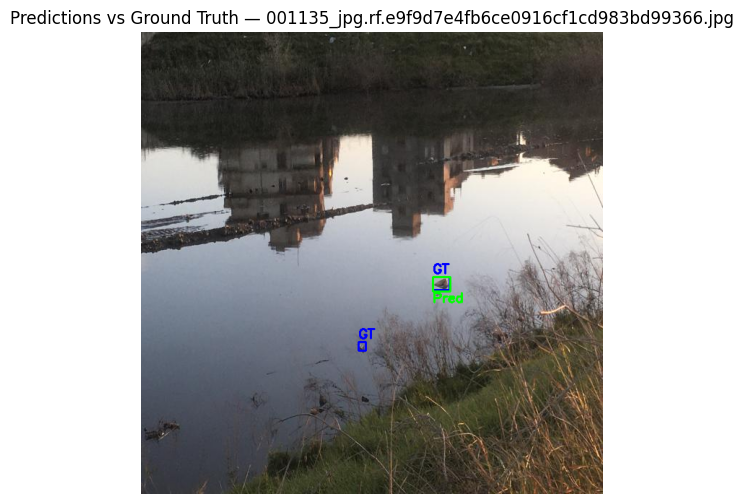

In [3]:
import matplotlib.pyplot as plt
import random

# Choose N random images to visualize
num_samples = 5
sample_images = random.sample(image_files, min(num_samples, len(image_files)))

for img_file in sample_images:
    base = os.path.splitext(img_file)[0]
    label_path = os.path.join(label_dir, base + ".txt")
    img_path = os.path.join(image_dir, img_file)

    image = cv2.imread(img_path)
    if image is None:
        continue
    draw = image.copy()
    h, w = image.shape[:2]

    # --- Ground Truth Boxes (Red) ---
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                if class_id in trash_class_ids:
                    cx, cy, bw, bh = map(float, parts[1:])
                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)
                    cv2.rectangle(draw, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red for GT
                    cv2.putText(draw, "GT", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # --- Predicted Boxes (Green) ---
    results = model(image)
    for i, pred_cls in enumerate(results[0].boxes.cls):
        class_id = int(pred_cls)
        if class_id in trash_class_ids:
            box = results[0].boxes.xyxy[i].cpu().numpy()
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(draw, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for Prediction
            cv2.putText(draw, "Pred", (x1, y2 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Convert BGR to RGB for display
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(draw)
    plt.title(f"Predictions vs Ground Truth — {img_file}")
    plt.axis("off")
    plt.show()


## Video Annotation and Visualization Process

This section describes how we process and annotate video data to evaluate the model's performance in a dynamic, real-world setting. For each input video:

- **Video Loading:** The video is opened using OpenCV, and key properties such as frame rate, dimensions, and total frame count are extracted.
- **Frame-by-Frame Inference:** The model processes each frame independently, predicting bounding boxes for potential trash items.
- **Bounding Box Annotation:** For each frame:
  - Predictions that match the trash class criteria are drawn with green bounding boxes.
  - A text label (e.g., "trash") is added to clearly indicate the detected object.
- **Output Generation:** The annotated frames are saved into a new output video file with the same frame rate and dimensions as the original.
- **Visualization:** Finally, the output videos are embedded within the notebook using HTML video tags to facilitate an easy review of detection performance over time.
  
This pipeline allows us to observe the consistency and challenges of our model in handling continuous video data, highlighting issues such as reflections and background interference.


## Video Annotation and Visualization Process

This section describes how we process and annotate video data to evaluate the model's performance in a dynamic, real-world setting. For each input video:

- **Video Loading:** The video is opened using OpenCV, and key properties such as frame rate, dimensions, and total frame count are extracted.
- **Frame-by-Frame Inference:** The model processes each frame independently, predicting bounding boxes for potential trash items.
- **Bounding Box Annotation:** For each frame:
  - Predictions that match the trash class criteria are drawn with green bounding boxes.
  - A text label (e.g., "trash") is added to clearly indicate the detected object.
- **Output Generation:** The annotated frames are saved into a new output video file with the same frame rate and dimensions as the original.
- **Visualization:** Finally, the output videos are embedded within the notebook using HTML video tags to facilitate an easy review of detection performance over time.
  
This pipeline allows us to observe the consistency and challenges of our model in handling continuous video data, highlighting issues such as reflections and background interference.


In [ ]:
!pip install ultralytics --quiet
import cv2
import torch
from ultralytics import YOLO

# Load model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = YOLO("/kaggle/input/yolov12/pytorch/default/1/v12strain1.pt").to(device)

# Define trash class IDs from model's labels
model_names = model.names
trash_labels = set([
    'Bottle cap', 'Can', 'Juice Box', 'Juice box', 'Metal', 'Metal Waste',
    'Plastic', 'Plastic Bag', 'Plastic Bottle', 'Plastic Waste', 'Plastic bag',
    'Plastic bottle', 'Plastic cup', 'Plastic packaging', 'Plastic-Bottle',
    'Undefined trash', 'Wood', 'bottles', 'plastic'
])
trash_class_ids = {i for i, name in model_names.items() if name in trash_labels}

# Input & output video paths
input_video_path = [48,46,50,5]


# Open video
for i,input_video_path in enumerate(input_video_path):
    cap = cv2.VideoCapture(f"/kaggle/input/videos2/videos/Sequence_{input_video_path}.avi")
    
    # Get video info
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video_path = f"/kaggle/working/annotated_video{i}.mp4"
    # output_video_path2 = "/kaggle/working/annotated_video2.mp4"
    
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Processing {frame_count} frames...")
    
    # Frame-by-frame processing
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
    
        # Run inference
        results = model(frame)
    
        for i, pred_cls in enumerate(results[0].boxes.cls):
            class_id = int(pred_cls)
            if class_id in trash_class_ids:
                box = results[0].boxes.xyxy[i].cpu().numpy()
                conf = results[0].boxes.conf[i].item()
                x1, y1, x2, y2 = map(int, box)
                # label = f"{model_names[class_id]} {conf:.2f}"
    
                # Draw green bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, "trash", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
        out.write(frame)
    
    cap.release()
    out.release()
    print("Annotated video saved at:", output_video_path)



Processing 206 frames...

0: 384x640 (no detections), 17.8ms
Speed: 1.7ms preprocess, 17.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 14.1ms
Speed: 1.6ms preprocess, 14.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 14.0ms
Speed: 1.6ms preprocess, 14.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 14.4ms
Speed: 1.6ms preprocess, 14.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.9ms
Speed: 1.5ms preprocess, 13.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 14.1ms
Speed: 1.5ms preprocess, 14.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 14.0ms
Speed: 1.5ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 13.7ms
Speed: 1

- **Annotated Video 1:** 


<video width="800" controls>
  <source src="annotated_video.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>



- **Annotated Video 2:** 

<video width="800" controls>
  <source src="annotated_video_1.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>



- **Annotated Video 3:** 

<video width="800" controls>
  <source src="annotated_video_2.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>



- **Annotated Video 4:** 

<video width="800" controls>
  <source src="annotated_video_3.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>


## Limitations of the Current Baseline Model

The current baseline model, despite providing a useful starting point, has notable limitations:
- **Background Interference:** The model does not effectively distinguish between trash in water and similar objects in non-water contexts. This is a critical issue since the project focus is on trash found specifically in water.
- **Scale and Visibility Challenges:** The small size of some trash objects leads to less reliable detection, primarily due to the reduced visibility and lower spatial resolution in the feature maps.
- **Environmental Variability:** Changes in lighting, reflections, and water clarity across images and videos introduce noise that the baseline model is not yet robust enough to handle.
---

## Potential Improvements and Future Work

To address the challenges observed with the current baseline, several improvements can be considered:

1. **Water Region Masking:**
   - **Concept:** Limit the detection search area to regions corresponding to water. This can help filter out false positives by eliminating objects not located in the water.
   - **Implementation:** Use image segmentation to create a mask of the water region in each frame or image before applying the detection model. This preprocessing step should focus the detection algorithm on the target area and improve precision.


2. **Model Architecture Enhancements:**
   - **Attention Mechanisms:** Incorporate attention modules within the network to focus the model on the relevant parts of the image, further minimizing the misclassification of reflections or non-water objects.

3. **Post-processing Techniques:**
   - **Confidence Score Adjustment:** Implement a tailored thresholding strategy to filter out low-confidence predictions that likely represent false positives.

4. **Domain-Specific Training:**
   - **Transfer Learning:** Leverage a model pre-trained on datasets more closely related to environmental and water-based scenes. Fine-tuning on a curated dataset that focuses on water and trash could yield better performance.

By exploring these enhancements, future iterations of the model can achieve higher precision and recall, reduce the rate of false detections, and ultimately provide more reliable trash detection in water bodies.

---